# Vectors, Frames, and Transforms

A quick example using NetworkX to implement a basic graph algorithm.

Allen B. Downey

[MIT License](https://opensource.org/licenses/MIT)

In [1]:
# this line makes Jupyter show figures in the notebook
%matplotlib inline

`Vector` represents a Euclidean vector; it is implemented using a NumPy array of coordinates and a reference to the frame those coordinates are defined in.

In [2]:
class FrameError(ValueError):
    """Indicates an error related to Frames."""

class Vector:
    def __init__(self, array, frame=None):
        """A vector is an array of coordinates and a frame of reference.

        array: sequence of coordinates
        frame: Frame object
        """
        self.array = np.asarray(array)
        self.frame = frame

    def __str__(self):
        if self.frame == None:
            return '^{O}%s' % (str(self.array), )
        else:
            return '^{%s}%s' % (str(self.frame), str(self.array))
        
    def __repr__(self):
        return 'Frame(%s, %s)' % (str(self.frame), str(self.array))

    def __add__(self, other):
        if self.frame != other.frame:
            raise FrameError("Vectors must be relative to the same frame.")

        return Vector(self.array + other.array, self.frame)


`Rotation` represents a rotation matrix, one of several kinds of transformation matrices.  We'll use it as part of the implementation of `Transform`.

In [3]:
class Rotation:
    def __init__(self, array):
        self.array = array
    
    def __str__(self):
        return 'Rotation\n%s' % str(self.array)
    
    __repr__ = __str__


    def __neg__(self):
        return Rotation(-self.array)

    def __mul__(self, other):
        """Apply the rotation to a Vector."""
        return np.dot(self.array, other.array)

    __call__ = __mul__

    @staticmethod
    def from_axis(axis, theta):
        x, y, z = np.ravel(axis.array)
        c = np.cos(theta)
        u = 1.0-c
        s = np.sqrt(1.0-c*c)
        xu, yu, zu = x*u, y*u, z*u
        v1 = [x*xu + c, x*yu - z*s, x*zu + y*s]
        v2 = [x*yu + z*s, y*yu + c, y*zu - x*s]
        v3 = [x*zu - y*s, y*zu + x*s, z*zu + c]
        return Rotation(np.array([v1, v2, v3]))

    def to_axis(self):
        # return the equivalent angle-axis as (khat, theta)
        pass

    def transpose(self):
        return Rotation(np.transpose(self.array))

    inverse = transpose
    


A `Transform` is a rotation (represented by a `Rotation` object) and an origin (represented by a `Vector`).  The destination of the transform is the frame of the origin vector.  The source of the transform is provided as an argument.

When you create a transform, it adds itself to the source frame.

In [4]:
class Transform:
    """Represents a transform from one Frame to another."""

    def __init__(self, rot, org, source=None):
        """Instantiates a Transform.

        rot: Rotation object
        org: origin Vector
        source: source Frame
        """
        self.rot = rot
        self.org = org
        self.dest = org.frame
        self.source = source
        self.source.add_transform(self)

    def __str__(self):
        """Returns a string representation of the Transform."""
        if self.dest == None:
            return '%s' % self.source.name
            return '_{%s}^{O}T' % self.source.name
        else:
            return '_{%s}^{%s}T' % (self.source.name, self.dest.name)
        
    __repr__ = __str__
            
    def __mul__(self, other):
        """Applies a Transform to a Vector or Transform."""
        if isinstance(other, Vector):
            return self.mul_vector(other)

        if isinstance(other, Transform):
            return self.mul_transform(other)

    __call__ = __mul__

    def mul_vector(self, p):
        """Applies a Transform to a Vector.

        p: Vector

        Returns: Vector
        """
        if p.frame != self.source:
            raise FrameError(
                "The frame of the vector must be the source of the transform")
        return Vector(self.rot * p, self.dest) + self.org

    def mul_transform(self, other):
        """Applies a Transform to another Transform.

        other: Transform

        Returns Transform
        """
        if other.dest != self.source:
            raise FrameError(
                "This frames source must be the other frame's destination.")

        rot = Rotation(self.rot * other.rot)
        t = Transform(rot, self * other.org, other.source)
        return t

    def inverse(self):
        """Computes the inverse transform.

        Returns: Transform
        """
        irot = self.rot.inverse()
        iorg = Vector(-(irot * self.org), self.source)
        t = Transform(irot, iorg, self.dest)
        return t



A `Frame` has a name and a dictionary that includes the frames we can reach directly from this frame, and the transform that gets there.

The `roster` is a list of all frames.

In [5]:
class Frame:
    """Represents a frame of reference."""

    # list of Frames
    roster = []
    
    def __init__(self, name):
        """Instantiate a Frame.

        name: string
        """
        self.name = name
        self.transforms = {}
        Frame.roster.append(self)

    def __str__(self): 
        return self.name
    
    __repr__ = __str__

    def add_transform(self, transform):
        """A frames is defined by a Transform relative to another Frame.

        transform: Transform object
        """
        if transform.source != self:
            raise FrameError("Source of the transform must be this Frame.")

        if transform.dest:
            self.transforms[transform.dest] = transform

    def dests(self):
        """Returns a list of the Frames we know how to Transform to."""
        return self.transforms.keys()

We'll start with one frame that is not defined relative to any other frame.

In [6]:
origin = Frame('O')
origin

O

Now we'll create Frame `A`, which is defined by a transform relative to `O`.

The string representation of a `Frame` is in LaTex.

In [7]:
import numpy as np

theta = np.pi/2
xhat = Vector([1, 0, 0], origin)
rx = Rotation.from_axis(xhat, theta)
a = Frame('A')
t_ao = Transform(rx, xhat, a)
t_ao

_{A}^{O}T

We can use `IPython.display` to render the LaTeX:

In [8]:
from IPython.display import Math

def render(obj):
    return Math(str(obj))

Here's the usual notation for the transform from `A` to `O`.

In [9]:
render(t_ao)

<IPython.core.display.Math object>

Here's Frame `B`, defined relative to `A` by a rotation around the `yhat` axis.

In [10]:
yhat = Vector([0, 1, 0], a)
ry = Rotation.from_axis(yhat, theta)
b = Frame('B')
t_ba = Transform(ry, yhat, b)
render(t_ba)

<IPython.core.display.Math object>

A Frame `C`, defined relative to `B` by a rotation around the `zhat` axis.

In [11]:
zhat = Vector([0, 0, 1], b)
rz = Rotation.from_axis(zhat, theta)
c = Frame('C') 
t_cb = Transform(rz, zhat, c)
render(t_cb)

<IPython.core.display.Math object>

Now let's make a vector defined in `C`.

In [12]:
p_c = Vector([1, 1, 1], c)
render(p_c)

<IPython.core.display.Math object>

And we can transform it to `B`:

In [13]:
p_b = t_cb(p_c)
render(p_b)

<IPython.core.display.Math object>

Then to `A`:

In [14]:
p_a = t_ba(p_b)
render(p_a)

<IPython.core.display.Math object>

And finally to `O`.

In [15]:
p = t_ao(p_a)
render(p)

<IPython.core.display.Math object>

If we didn't know how to get from one frame to another, we could search for the shortest path from the start frame to the destination.  I'll use NetworkX.

In [16]:
import networkx as nx

The following function adds the edges from a given frame to the graph.

In [17]:
def add_edges(G, frame):
    for neighbor, transform in frame.transforms.items():
        G.add_edge(frame, neighbor, transform=transform)

And here's how we can make a graph from a list of frames.

In [18]:
def make_graph(frames):
    G = nx.DiGraph()
    for frame in frames:
        add_edges(G, frame)
    return G

Here's the list of frames:

In [19]:
frames = Frame.roster
frames

[O, A, B, C]

And a dictionary that maps from each frame to its label:

In [20]:
labels = dict([(frame, str(frame)) for frame in frames])
labels

{O: 'O', A: 'A', B: 'B', C: 'C'}

So we can show the frames, and transforms between them, graphically.

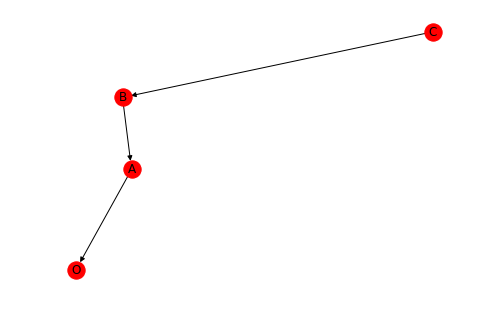

In [21]:
G = make_graph(Frame.roster)
nx.draw(G, labels=labels)

In [22]:
nx.shortest_path(G, c, origin)

[C, B, A, O]

When we apply a transform to a vector, we get a vector in a new frame.

When we apply a transform to another transform, we get a new transform that composes the two transforms.

For example `cbao`, below, composes the transforms from C to B, C to A, and A to O.  The result is a transform directly from C to O.

In [23]:
cbao = t_ao(t_ba(t_cb))
render(cbao)

<IPython.core.display.Math object>

In [24]:
p = cbao(p_c)
render(p)

<IPython.core.display.Math object>

When we create the new transform, it gets added to the network, creating shortcuts.

If we draw the network again, we can see the new links.

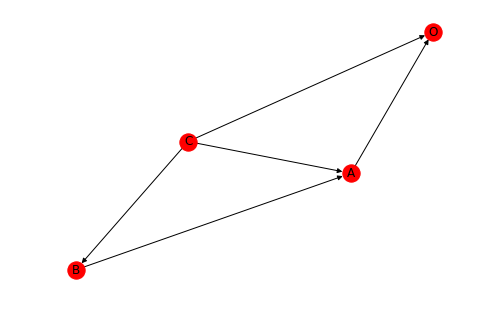

In [25]:
G = make_graph([origin, a, b, c])
nx.draw(G, labels=labels)

And if we find the shortest path, its shorter now.

In [26]:
nx.shortest_path(G, c, origin)

[C, O]

We can also compute an inverse transform that goes in the other direction.

In [27]:
inv = cbao.inverse()
render(inv)

<IPython.core.display.Math object>

And confirm that it gets us back where we started.

In [28]:
p_c = inv(p)
render(p_c)

<IPython.core.display.Math object>